1. Importing Datasets
2. Data Cleaning
3. Visulalizing pairplots
4. Building Artificial Neural Networks
5. Making submission file

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv("flight_delays_train.csv")
train.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N


Understanding the dataset, and confirming that any incorrect value does not exist in it by checking with total number of months etc.

In [3]:
for col in train.columns:
    uni = train[col].nunique()
    print("Columns: ",col," ","Unique Values: ",uni)

Columns:  Month   Unique Values:  12
Columns:  DayofMonth   Unique Values:  31
Columns:  DayOfWeek   Unique Values:  7
Columns:  DepTime   Unique Values:  1300
Columns:  UniqueCarrier   Unique Values:  22
Columns:  Origin   Unique Values:  289
Columns:  Dest   Unique Values:  289
Columns:  Distance   Unique Values:  1310
Columns:  dep_delayed_15min   Unique Values:  2


Checking for null values in dataset

In [4]:
train.isnull().sum().sort_values()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
UniqueCarrier        0
Origin               0
Dest                 0
Distance             0
dep_delayed_15min    0
dtype: int64

In [5]:
#Features:

#Month, DayofMonth, DayOfWeek
#DepTime – departure time
#UniqueCarrier – code of a company-career
#Origin – flight origin
#Dest – flight destination
#Distance, distance between Origin and Dest airports
#dep_delayed_15min – target

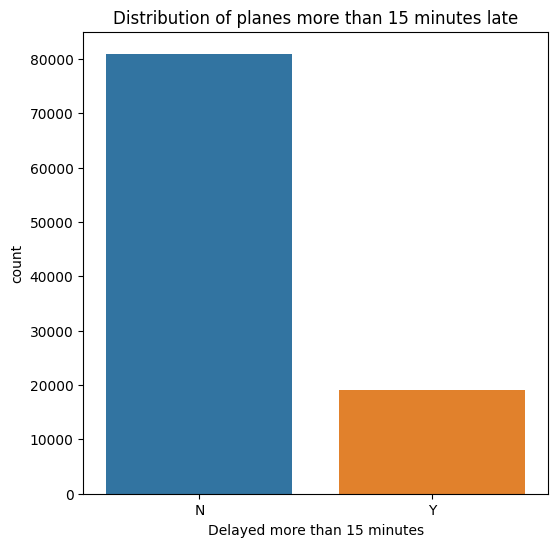

In [6]:
#Target Distribution
plt.figure(figsize=(6, 6))
sns.countplot(x='dep_delayed_15min', data=train)
plt.xlabel('Delayed more than 15 minutes')
plt.title('Distribution of planes more than 15 minutes late')
plt.show()

The dataset has no null value

In [7]:
test = pd.read_csv("flight_delays_test.csv")

In [8]:
test.shape

(100000, 8)

In [9]:
train.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N


Removing the alphabets from Day, Month and Week columns

In [10]:
def clean_alpha(df):
    df.Month = df.Month.str.extract(r"(\d+)").astype(int)
    df.DayofMonth = df.DayofMonth.str.extract(r"(\d+)").astype(int)
    df.DayOfWeek = df.DayOfWeek.str.extract(r"(\d+)").astype(int)


clean_alpha(train)
clean_alpha(test)
train.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N


Encoding all the alphabets based data into numbers

In [11]:
label_encoding = LabelEncoder()
def encode(df):
    df['UniqueCarrier'] = label_encoding.fit_transform(df['UniqueCarrier'])
    df['Origin'] = label_encoding.fit_transform(df['Origin'])
    df['Dest'] = label_encoding.fit_transform(df['Dest'])

encode(train)
train['dep_delayed_15min'] = label_encoding.fit_transform(train['dep_delayed_15min'])
#Writing this seperately since, dep_delayed_15min column is not present in test dataframe


encode(test)
train.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,0,18,78,732,0
1,4,20,3,1548,18,217,171,834,0
2,9,2,5,1422,20,228,59,416,0


Create new features

In [12]:
# Create New Features - Departure hour and minute from Departure time
def newFeatures(df):
    df['Dep_hour'] =  df['DepTime']//100
    df['Dep_minute'] =  df['DepTime']%100
    df['Dep_hour'].replace(to_replace=[24,25], value=0, inplace=True)

    # give more importance to hour variable
    df['Dep_hour2'] = df['Dep_hour'] ** 2
    df['Dep_hour3'] = df['Dep_hour'] ** 4

    #Combining Origin and Destination to have the route
    df['Route'] = df['Origin'] + df['Dest'] 

    df['UniqueCarrier_Origin'] = df['UniqueCarrier'].astype(str) + "_" + df['Origin'].astype(str) #Combining UniqueCarrier and Origin to have a new feature
    df['UniqueCarrier_Dest'] = df['UniqueCarrier'].astype(str) + "_" + df['Dest'].astype(str) #Combining UniqueCarrier and Dest to have a new feature

    #Flight is in the Weekend or not
    df['is_weekend'] = (df['DayOfWeek'] == 6) | (df['DayOfWeek'] == 7) 

    df['summer'] = (df['Month'].isin([6, 7, 8]))
    df['autumn'] = (df['Month'].isin([9, 10, 11]))
    df['winter'] = (df['Month'].isin([12, 1, 2]))
    df['spring'] = (df['Month'].isin([3, 4, 5]))

    df['DayTime'] = 0
    df.loc[df.DepTime <= 600 , 'DepTime_bin'] = 0
    df.loc[(df.DepTime > 600) & (df.DepTime <= 1200), 'DepTime_bin'] = 1
    df.loc[(df.DepTime > 1200) & (df.DepTime <= 1800), 'DepTime_bin'] = 2
    df.loc[(df.DepTime > 1800) & (df.DepTime <= 2600), 'DepTime_bin'] = 3

    df['Dist_bin'] = 0
    df.loc[df.Distance <= 500 , 'Dist_bin'] = 0
    df.loc[(df.Distance > 500) & (df.Distance <= 1000), 'Dist_bin'] = 1
    df.loc[(df.Distance > 1000) & (df.Distance <= 1500), 'Dist_bin'] = 2
    df.loc[(df.Distance > 1500) & (df.Distance <= 2000), 'Dist_bin'] = 3
    df.loc[(df.Distance > 2000) & (df.Distance <= 2500), 'Dist_bin'] = 4
    df.loc[df.Distance > 2500, 'Dist_bin'] = 5

newFeatures(test)
newFeatures(train)
test = test.drop(['Distance'], axis=1)
train = train.drop(['Distance'], axis=1)

train.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,dep_delayed_15min,Dep_hour,Dep_minute,...,UniqueCarrier_Origin,UniqueCarrier_Dest,is_weekend,summer,autumn,winter,spring,DayTime,DepTime_bin,Dist_bin
0,8,21,7,1934,0,18,78,0,19,34,...,0_18,0_78,True,True,False,False,False,0,3.0,1
1,4,20,3,1548,18,217,171,0,15,48,...,18_217,18_171,False,False,False,False,True,0,2.0,1
2,9,2,5,1422,20,228,59,0,14,22,...,20_228,20_59,False,False,True,False,False,0,2.0,0


In [13]:
#afficher toutes les valeurs differentes de daytime
train['DepTime_bin'].unique()




array([3., 2., 1., 0.])

In [14]:
df_t = pd.crosstab(train.Dep_hour,train.dep_delayed_15min)
df_t.head()

dep_delayed_15min,0,1
Dep_hour,,
0,145,192
1,30,46
2,15,12
3,3,5
4,35,3


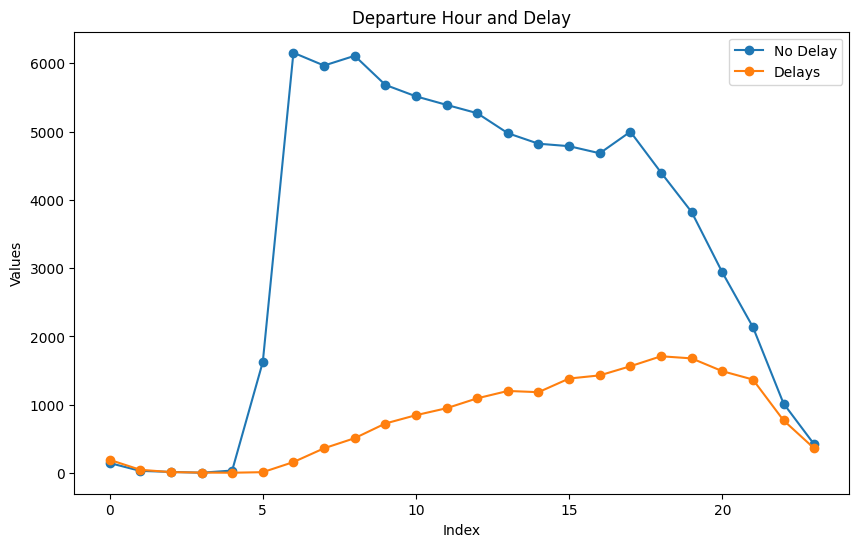

In [15]:
import matplotlib.pyplot as plt

# Assuming df_t is your DataFrame and it is already defined
# df_t should have columns 'N' and 'Y', and an index for x-axis

plt.figure(figsize=(10, 6))

# Plotting 'No Delay' trace
plt.plot(df_t.index, df_t[0], marker='o', linestyle='-', label='No Delay')

# Plotting 'Delays' trace
plt.plot(df_t.index, df_t[1], marker='o', linestyle='-', label='Delays')

# Adding title and labels
plt.title('Departure Hour and Delay')
plt.xlabel('Index')  # You can change 'Index' to the appropriate x-axis label
plt.ylabel('Values')  # You can change 'Values' to the appropriate y-axis label

# Adding legend
plt.legend()

# Display the plot
plt.show()


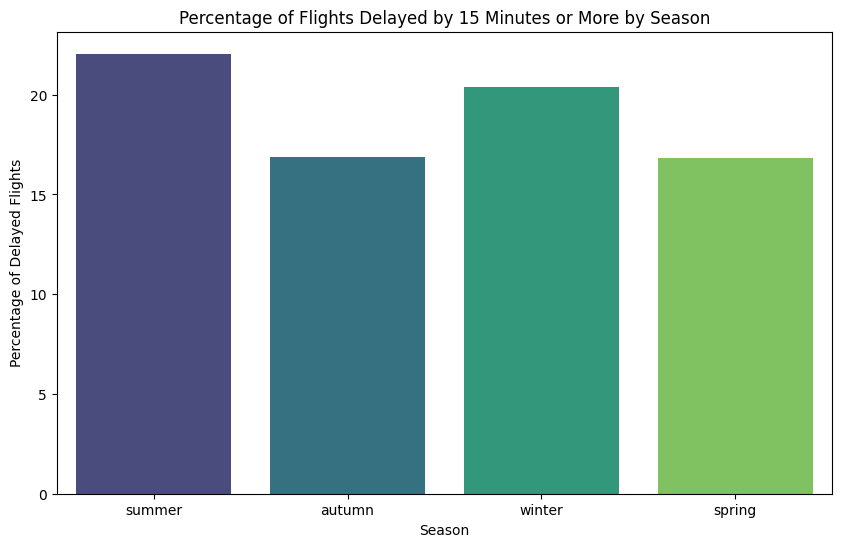

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_seasonal_delay_percentages(df):
    seasons = ['summer', 'autumn', 'winter', 'spring']
    delay_percentages = []

    for season in seasons:
        season_df = df[df[season]]
        delay_percentage = season_df['dep_delayed_15min'].mean() * 100  # Convert to percentage
        delay_percentages.append(delay_percentage)
    
    return pd.DataFrame({'Season': seasons, 'Delay_Percentage': delay_percentages})

def plot_seasonal_delays(delay_percentages_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Season', y='Delay_Percentage', data=delay_percentages_df, palette='viridis')
    plt.title('Percentage of Flights Delayed by 15 Minutes or More by Season')
    plt.xlabel('Season')
    plt.ylabel('Percentage of Delayed Flights')
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame
delay_percentages_df = calculate_seasonal_delay_percentages(train)
plot_seasonal_delays(delay_percentages_df)


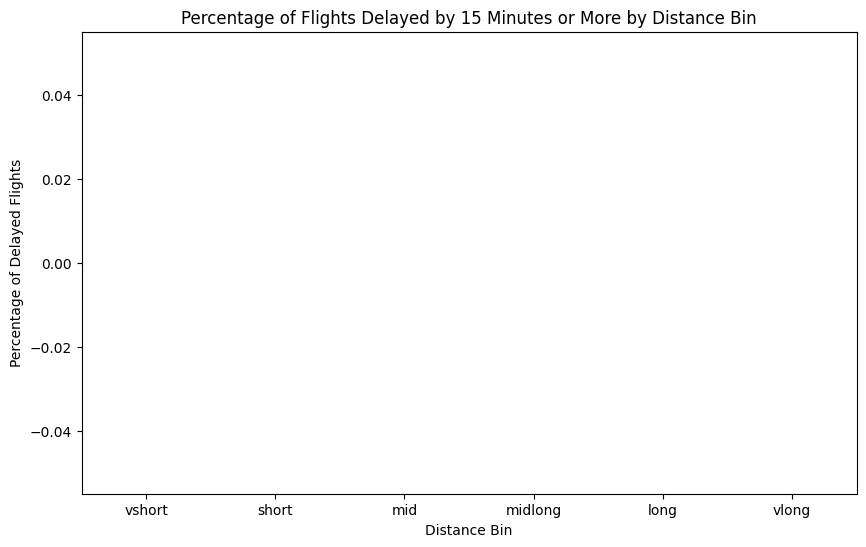

In [17]:
def calculate_distance_bin_delay_percentages(df):
    distance_bins = ['vshort', 'short', 'mid', 'midlong', 'long', 'vlong']
    delay_percentages = []

    for distance_bin in distance_bins:
        bin_df = df[df['Dist_bin'] == distance_bin]
        delay_percentage = bin_df['dep_delayed_15min'].mean() * 100  # Convert to percentage
        delay_percentages.append(delay_percentage)
    
    return pd.DataFrame({'DistanceBin': distance_bins, 'Delay_Percentage': delay_percentages})

def plot_distance_bin_delays(delay_percentages_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='DistanceBin', y='Delay_Percentage', data=delay_percentages_df, palette='viridis')
    plt.title('Percentage of Flights Delayed by 15 Minutes or More by Distance Bin')
    plt.xlabel('Distance Bin')
    plt.ylabel('Percentage of Delayed Flights')
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame
distance_bin_delay_percentages_df = calculate_distance_bin_delay_percentages(train)
plot_distance_bin_delays(distance_bin_delay_percentages_df)


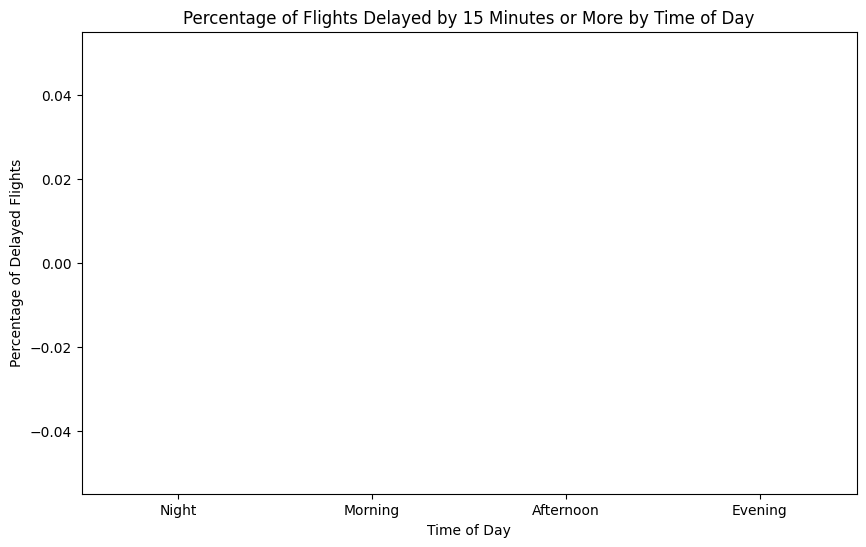

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_time_of_day_delay_percentages(df):
    time_bins = ['Night', 'Morning', 'Afternoon', 'Evening']
    delay_percentages = []

    for time_bin in time_bins:
        bin_df = df[df['DepTime_bin'] == time_bin]
        delay_percentage = bin_df['dep_delayed_15min'].mean() * 100  # Convert to percentage
        delay_percentages.append(delay_percentage)
    
    return pd.DataFrame({'TimeOfDay': time_bins, 'Delay_Percentage': delay_percentages})

def plot_time_of_day_delays(delay_percentages_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='TimeOfDay', y='Delay_Percentage', data=delay_percentages_df, palette='viridis')
    plt.title('Percentage of Flights Delayed by 15 Minutes or More by Time of Day')
    plt.xlabel('Time of Day')
    plt.ylabel('Percentage of Delayed Flights')
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame
time_of_day_delay_percentages_df = calculate_time_of_day_delay_percentages(train)
plot_time_of_day_delays(time_of_day_delay_percentages_df)


In [19]:
X = train.drop(['dep_delayed_15min'],axis=1)
y = train['dep_delayed_15min']

In [20]:
train.shape

(100000, 23)

Understanding the pairplot between all the parameters with dep_delayed_15min

In [21]:
#sns.pairplot(train,hue = 'dep_delayed_15min')

Now the pairplot clearly insit that any linear classification will be useless, because of high overlaps. ALgortihms like RandomForestRegressor will be efficient. However, in this notebook we will stick towards developing Artificial Neural Network

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.fit_transform(test)

After scaling the data we can feed this into a deep leaning model

In [23]:
model = None
model = keras.Sequential([
    layers.Input(shape=(22,)),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])

#explaining the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2944      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [29]:
history = model.fit(X_scaled, y, epochs=30, batch_size=150, validation_split=0.25, shuffle=True)

Epoch 1/30
500/500 [==============================] - 6s 9ms/step - loss: 0.4556 - accuracy: 0.8099 - val_loss: 0.4544 - val_accuracy: 0.8089
Epoch 2/30
500/500 [==============================] - 4s 9ms/step - loss: 0.4555 - accuracy: 0.8098 - val_loss: 0.4543 - val_accuracy: 0.8090
Epoch 3/30
500/500 [==============================] - 4s 9ms/step - loss: 0.4551 - accuracy: 0.8105 - val_loss: 0.4533 - val_accuracy: 0.8090
Epoch 4/30
500/500 [==============================] - 4s 8ms/step - loss: 0.4549 - accuracy: 0.8103 - val_loss: 0.4538 - val_accuracy: 0.8100
Epoch 5/30
500/500 [==============================] - 4s 8ms/step - loss: 0.4555 - accuracy: 0.8099 - val_loss: 0.4537 - val_accuracy: 0.8108
Epoch 6/30
500/500 [==============================] - 4s 9ms/step - loss: 0.4548 - accuracy: 0.8103 - val_loss: 0.4530 - val_accuracy: 0.8094
Epoch 7/30
500/500 [==============================] - 5s 10ms/step - loss: 0.4551 - accuracy: 0.8104 - val_loss: 0.4543 - val_accuracy: 0.8089
Epoch

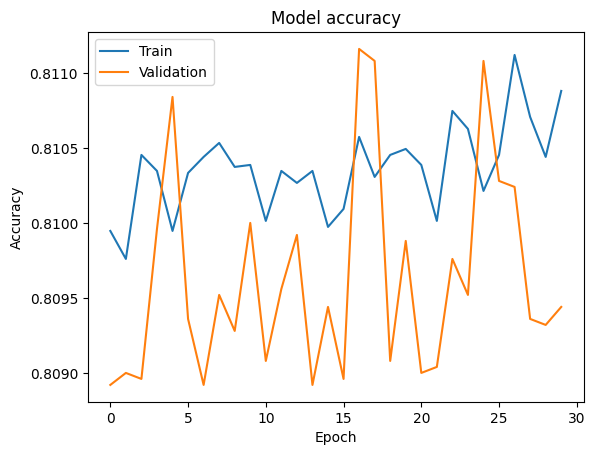

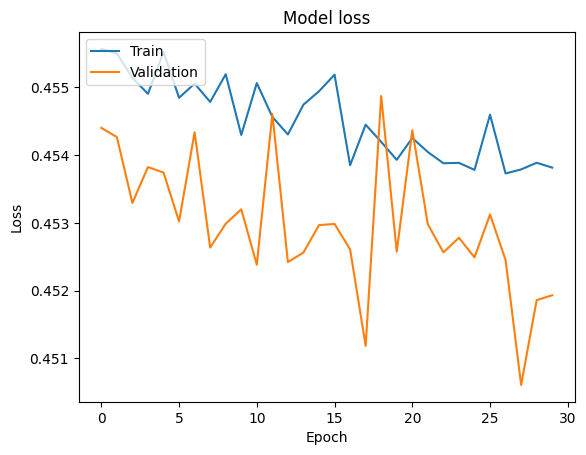

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [31]:
pred = model.predict(test_scaled)

3125/3125 [==============================] - 6s 2ms/step


Score will be around 0.69

In [32]:
pred = pred.flatten()
sub = pd.Series(pred,name = 'dep_delayed_15min')
sub = sub.reset_index()
sub.columns = ['id', 'dep_delayed_15min']
sub.to_csv("sub.csv",index = False)
sub.head()

,id,dep_delayed_15min
0,0,0.070441
1,1,0.074362
2,2,0.067053
3,3,0.208345
4,4,0.233608


#A FAIRE pour tenter un meilleur score 


In [33]:
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score

model_ctb = CatBoostClassifier(iterations=3000, loss_function='Logloss',
                               l2_leaf_reg=0.8, od_type='Iter',
                               random_seed=17, silent=True)
#model_ctb = GridSearchCV(model_ctb, {'learning_rate':[0.5, 0.1], 'n_estimators':[500, 1000]})
model_ctb.fit(X_train, y_train.astype(int), cat_features=[2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20])
predictions = model_ctb.predict_proba(X_val)[:, 1]
accuracy = roc_auc_score(y_val.astype(int), predictions)
print('Accuracy Catboost: ', accuracy)


,id,dep_delayed_15min
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
model_ctb.fit(X, y.astype(int), cat_features=[2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [ ]:
predictions = model_ctb.predict_proba(new_test[feature_columns])[:, 1]


In [ ]:
submission = pd.DataFrame({'id':range(100000),'dep_delayed_15min':predictions})
submission.head(900)

In [ ]:
filename = 'flight_delay.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)